In [8]:
import geopandas as gpd
import pandas as pd
from shapely import Point
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

In [9]:
## helpers
def parse_coords(q):
    '''
    helper for parsing coordinates in the form 'N 56° 12'' to decimal degrees
    '''
    parts = q.split(' ')
    deg = parts[1].split('°')[0]
    min = parts[2].split("'")[0]
    if parts[0] in ['W', 'S']:
        return -1 * (int(deg) + int(min)/60)
    else:
        return int(deg) + int(min)/60

def remove_symbol(series,sym):
    return series.str.replace(sym,'')

def clean(tmp):
    '''
    for tidying up the Distance (km) column
    converting ~56 to 56
    where a range is given (40-60) the average (50) is returned
    '''
    wild = []
    for chars in tmp:
        for char in chars:
            if char not in ['0','1','2','3','4','5','6','7','8','9','.']:
                wild.append(char)
    wild = set(wild)
        
    needs_cleaning=  [i for i,s in enumerate(tmp) if True in [w in s for w in wild]]
    wild.remove('-')
    
    for i in needs_cleaning:
        for w in wild:
            if w in tmp[i]:
                tmp[i] = tmp[i].replace(w,'')
            else:
                tmp[i] = tmp[i]
                
    for i in needs_cleaning:
        if '-' in tmp[i]:
            tmp[i] = (float(tmp[i].split('-')[0]) + float(tmp[i].split('-')[-1])) / 2
        
    return [float(t) for t in tmp]

In [10]:
## for country outline
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
oceans = gpd.read_file('../day3_polygons/ne_10m_ocean.zip')

# get data from earth impact database
tbl = pd.read_html('http://www.passc.net/EarthImpactDatabase/New%20website_05-2018/NorthAmerica.html')
impacts = tbl[1]
impacts.columns = impacts.loc[0,:]
impacts = impacts.drop(index=0)

# clean up Diameter column (removing ~ > - symbols)
impacts['Diameter (km)'] = clean(impacts['Diameter (km)'].tolist())

## clean up Age (Ma)* column (removing ~ < -) (bit messy)
## there has to be a better way of doing this!
impacts['age'] = pd.Series()
impacts['uncertainty'] = pd.Series()

impacts['age'] = remove_symbol(impacts['Age (Ma)*'],'*')
impacts['age'] = remove_symbol(impacts['Age (Ma)*'],'~')

## splitting ages when given as a range (40-60) --> 50
impacts.loc[
    impacts['Age (Ma)*'].str.contains('-'),'age'
    ] = (impacts.loc[impacts['Age (Ma)*'].str.contains('-'),'age']
         .apply(lambda q: (float(q.split('-')[0]) + float(q.split('-')[1])) / 2))

# splitting out ages when given with uncertainty
impacts.loc[
    impacts['Age (Ma)*'].str.contains('±'),'age'
    ] = (impacts.loc[impacts['Age (Ma)*'].str.contains('±'), 'Age (Ma)*']
         .str
         .split('±')
         .apply(lambda q: q[0]))

impacts.loc[
    impacts['Age (Ma)*'].str.contains('±'),'uncertainty'
    ] = (impacts.loc[impacts['Age (Ma)*'].str.contains('±'),'Age (Ma)*']
         .str.split('±')
         .apply(lambda q: q[-1])
         )

## spltting out ages when given as greater than and less than
lt,gt = [impacts['Age (Ma)*'].str.contains(q) for q in ['<', '>']]

impacts.loc[(lt&gt),'age'] = (
    impacts.loc[(lt & gt),'Age (Ma)*']
    .str.replace('<','')
    .str.replace('>','')
    .apply(lambda q: (float(q.split(', ')[0]) + float(q.split(', ')[1])) / 2))

# splitting out ages when given as <
impacts.loc[
    impacts['age'].str.contains('<')==True,'age'
    ] = impacts.loc[impacts['age'].str.contains('<')==True,'age'].str.replace('<','')

# convert all the ages
impacts['age'] = impacts['age'].astype('float')


## parse coordinates and construct geodata frame

impacts['lat_dd'] = impacts['Latitude'].apply(lambda q: parse_coords(q))
impacts['lon_dd'] = impacts['Longitude'].apply(lambda q: parse_coords(q))
impacts['geometry'] = [Point(p) for p in zip(impacts['lon_dd'], impacts['lat_dd'])]

impacts = gpd.GeoDataFrame(impacts, crs=4326)

C:\Users\s1759665\AppData\Local\Temp\ipykernel_19808\4120865234.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


# plotting

In [11]:
# set projection
prj = ccrs.AlbersEqualArea(central_longitude=-96,
                           standard_parallels=[20,60],
                           globe=ccrs.Globe(datum='NAD83'))

Text(0.01, -0.02, 'by:tlohde')

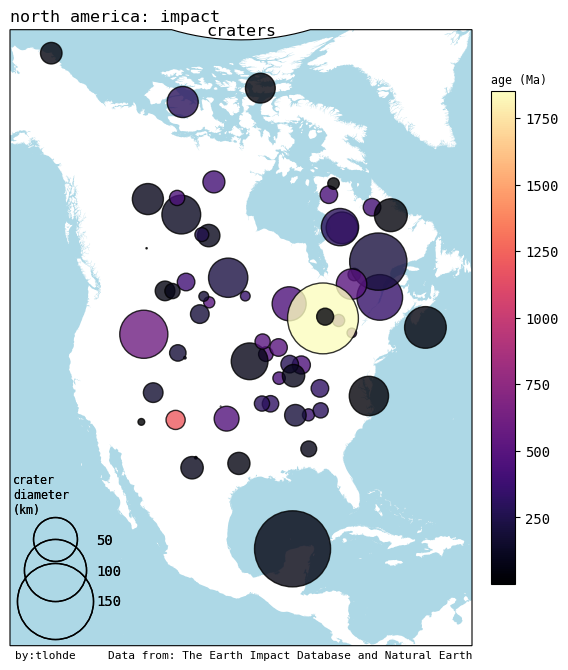

In [16]:
fig,ax = plt.subplots(figsize=[8,8],
                      subplot_kw={'projection':prj})

oceans.to_crs(prj).plot(facecolor='lightblue', zorder=0,
                        ec='none',
                        ax=ax)

impacts.to_crs(prj).plot(column='age',
                         fc='none', ec='k',
                         markersize=impacts['Diameter (km)']*20,
                         cmap='magma', legend=True,
                         legend_kwds={'shrink':0.8,'pad':0.03},
                         alpha=0.8, ax=ax)

# colorbar title
fig.axes[1].set_title('age (Ma)', fontsize='small', loc='left')#, ha='left')

# create 2nd legend for point size...code courtesy of this answer on SO: https://stackoverflow.com/a/73354795
_, bins = pd.cut(impacts["Diameter (km)"]*20, bins=3, precision=0, retbins=True)
ax.add_artist(
    ax.legend(
        handles=[mlines.Line2D([], [], color="black", fillstyle='none',
                               lw=0, marker="o", markersize=np.sqrt(b),
                               label=str(int(b)),) 
                 for i, b in enumerate(bins[1:])],
        labels = [str(int(v)) for v in np.round(bins[1:]/20).tolist()],
        loc='lower left', bbox_to_anchor=(0.04,0.04),
        title='crater\ndiameter\n(km)', alignment='left',
        title_fontsize='small',
        frameon=False,
        handletextpad=2,
        labelspacing=1.2
        )
    )

ax.set_xlim(-3e6, 3e6)
ax.set_ylim(1e6, 9e6)

ax.get_legend().get_title().set_position((-28,0))
ax.set_title('north america: impact', loc='left')

ax.annotate(text='craters',
            xy=(0.5,0.99), 
            xycoords='axes fraction', 
            ha='center',
            c='k', 
            fontsize=12,
            font='DejaVu Sans Mono')

ax.annotate(text='Data from: The Earth Impact Database and Natural Earth',
            xy=(1,-0.02), 
            xycoords='axes fraction', 
            ha='right',
            c='k', 
            fontsize=8,
            font='DejaVu Sans Mono')

ax.annotate(text='by:tlohde',
            xy=(0.01,-0.02), 
            xycoords='axes fraction',
            ha='left',
            fontsize=8,
            font='DejaVu Sans Mono')

In [17]:
fig.savefig('day10.png', bbox_inches='tight', dpi=300)

In [14]:
# if you want actual sized craters
# impacts['actual_size'] = impacts.to_crs(prj).apply(lambda q: q['geometry'].buffer(q['Diameter (km)']*1000), axis=1)
# impacts.set_geometry('actual_size').plot(column='age',
#                                          cmap='magma',
#                                          legend=True,
#                                          legend_kwds={'label':'Age (Ma)'},
#                                          ax=ax)